In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import cross_val_score, StratifiedKFold

In [6]:
df = pd.read_csv("Telco_Customer_Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df["tenure"].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

### Missing Values in the TotalCharges Column

In [6]:
#Note that there is nothing in the TotalCharges Column for clients who just opened their contract with this company (tenure = 0)
#Ask professor what to do here

missing = df[df["tenure"] == 0][["TotalCharges"]]
missing

,TotalCharges
488,
753,
936,
1082,
1340,
3331,
3826,
4380,
5218,
6670,


### Replace Missing Values with 0, since "tenure" = 0 for all of these values, so the customer has not yet started his contract

In [7]:
df["TotalCharges"] = df["TotalCharges"].str.strip()
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0).replace("", 0)

In [8]:
condition_0 = df["TotalCharges"] == 0
df[condition_0]["Churn"]

488     No
753     No
936     No
1082    No
1340    No
3331    No
3826    No
4380    No
5218    No
6670    No
6754    No
Name: Churn, dtype: object

## EDA (Exploratory Data Analysis)

## Let's perform Data Visualization and analyze correlations between features in the Data Set

## Average Total Cost of Churned vs Stayed

In [9]:
df["TotalCharges"].dtype

dtype('O')

In [10]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [11]:
charges_churn = df.groupby("Churn")[["TotalCharges"]].mean().round(2)
charges_churn

,TotalCharges
Churn,
No,2549.91
Yes,1531.80


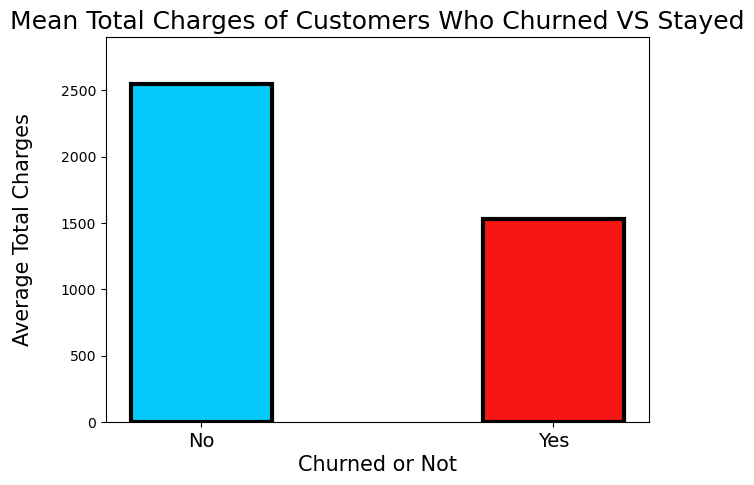

In [12]:
x = charges_churn.index
height = charges_churn['TotalCharges']

plt.figure(figsize = (7,5))
plt.bar(x, height, width = 0.4, color = ["#04CBFC", "#F61714"], edgecolor = "black", linewidth = 3)
plt.title("Mean Total Charges of Customers Who Churned VS Stayed", fontsize = 18, color = "black");
plt.ylabel('Average Total Charges', labelpad = 20, fontsize = 15)
plt.ylim(ymax = 2900, ymin = 0)
plt.xlabel('Churned or Not', labelpad = 3, fontsize = 15)
plt.xticks(fontsize = 14);

## Average Monthly Cost of Churned vs Stayed

In [13]:
monthly_churn = df.groupby("Churn")[["MonthlyCharges"]].mean().round(2)
monthly_churn

#those that churned have a higher monthly cost 

,MonthlyCharges
Churn,
No,61.27
Yes,74.44


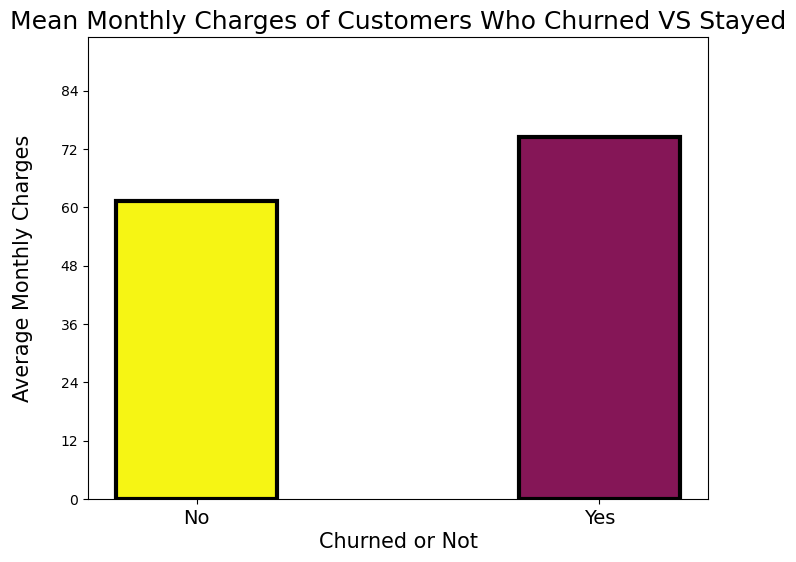

In [14]:
x = monthly_churn.index
height = monthly_churn['MonthlyCharges']

plt.figure(figsize = (8,6))
plt.bar(x, height, width = 0.4, color = ["#F6F514", "#851657"], edgecolor = "black", linewidth = 3)
plt.title("Mean Monthly Charges of Customers Who Churned VS Stayed", fontsize = 18, color = "black");
plt.ylabel('Average Monthly Charges', labelpad = 20, fontsize = 15)
plt.ylim(ymax = 95, ymin = 0)
plt.yticks(np.arange(0, 95, 12))
plt.xlabel('Churned or Not', labelpad = 3, fontsize = 15)
plt.xticks(fontsize = 14);

In [15]:
#How long do People who churned stay with this phone company? (tenure is in number of months)

df.groupby("Churn")[["tenure"]].mean().round(2)

,tenure
Churn,
No,37.57
Yes,17.98


## Number of Churners with Given Internet Service

In [16]:
pd.crosstab(df["InternetService"], df["Churn"])

Churn,No,Yes
InternetService,,
DSL,1962,459
Fiber optic,1799,1297
No,1413,113


Text(0, 0.5, 'Count')

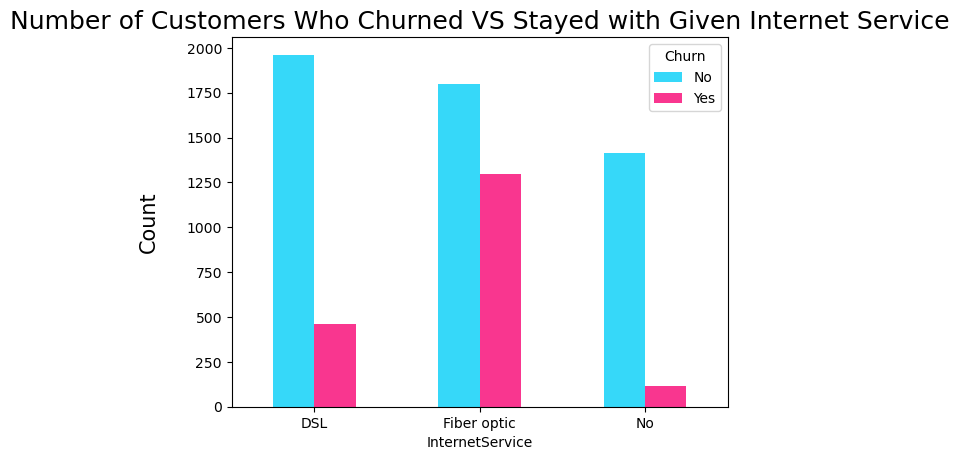

In [17]:
# now compare department of work and number of people who left
plt.style.use("default")
pd.crosstab(df["InternetService"], df["Churn"]).plot(kind = "bar", color = ["#36D8F9", "#F9368F"])
plt.title("Number of Customers Who Churned VS Stayed with Given Internet Service", fontsize = 18, color = "black");
plt.xticks(rotation = 0)
plt.ylabel("Count", labelpad = 20, fontsize = 15)

## Percent of People who Churned vs Stayed

In [18]:
churn = df.groupby('Churn')['Churn'].count() 
churn

Churn
No     5174
Yes    1869
Name: Churn, dtype: int64

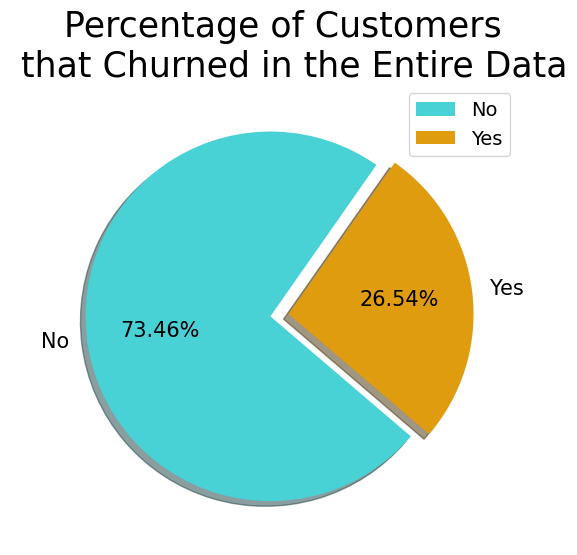

In [19]:
churn = df.groupby('Churn')['Churn'].count()   
churn_df = churn.to_frame()   

data = churn_df['Churn']
labels = churn_df.index

c = ["#49D2D6","#E09C0F"] 
e = [0.1, 0]

plt.figure(figsize=(8,6))  
plt.title("Percentage of Customers \n that Churned in the Entire Data", fontsize = 25, 
          color = 'black', pad=1);
plt.pie(data, labels=labels, colors=c, autopct = '%.2f%%', explode=e, shadow = True, 
        startangle = 55, textprops={'fontsize': 15})
plt.legend(loc = "best", fontsize = 14);

# Note: We have an imbalanced number of people who churned vs stayed in the dataset. We will have to use imbalanced data techniques before using prediction models

In [21]:
num_gender = df["gender"].value_counts()
num_gender

Male      3555
Female    3488
Name: gender, dtype: int64

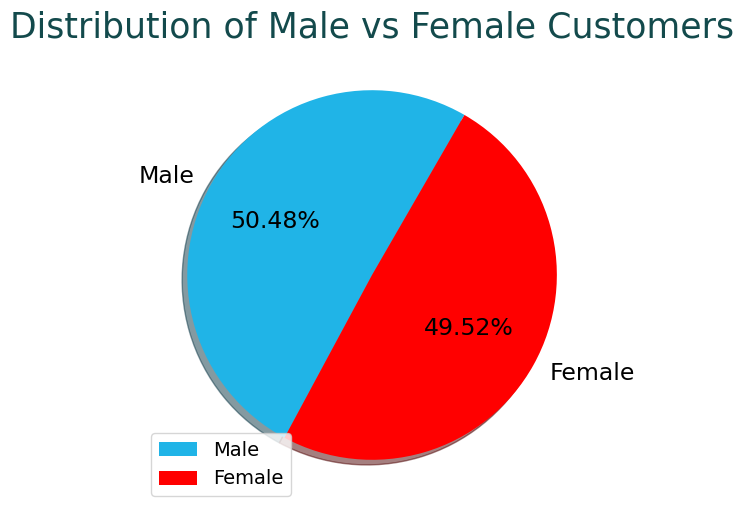

In [22]:
gender_df = num_gender.to_frame()    

data = gender_df["gender"]
labels = gender_df.index

c = ["#20B4E7", "red"]
# e = [0.08, 0]

plt.figure(figsize=(8,6))   
plt.title("Distribution of Male vs Female Customers", fontsize = 25, 
          color = "#134A4C", pad=1);
plt.pie(data, labels=labels, colors=c, autopct = '%.2f%%', shadow = True, 
        startangle = 60, textprops={'fontsize': 17})
plt.legend(loc = "lower left", fontsize = 14);

## Number of Males vs Females that Churned

In [23]:
pd.crosstab(df["gender"], df["Churn"])

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


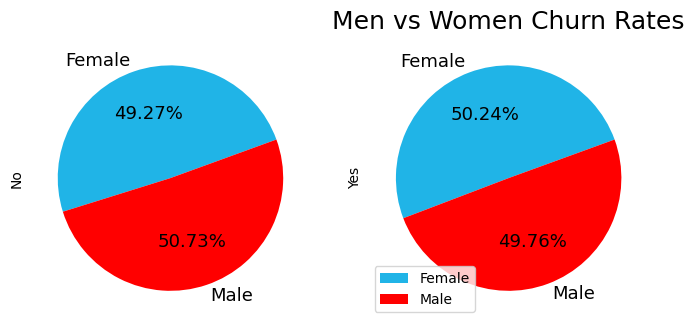

In [24]:
pd.crosstab(df["gender"], df["Churn"]).plot(kind = "pie", subplots=True, figsize=(8, 4), 
                                            colors = ["#20B4E7", "red"], legend = False, autopct = '%.2f%%',
                                            textprops={'fontsize': 13}, startangle = 20)
plt.title("Men vs Women Churn Rates", fontsize = 18, color = "black")
plt.legend(loc = "lower left");


## Monthly Charge of New Customers (tenure = 0) vs Old customers (tenure >= 12 months)

In [25]:
monthly_charge = []

In [26]:
condition_old_cust = df["tenure"] >= 12
mean_old = df[condition_old_cust]["MonthlyCharges"].mean().round(2)
mean_old

68.38

In [27]:
monthly_charge.append(mean_old)

In [28]:
condition_old_cust = df["tenure"] == 0
mean_new = df[condition_old_cust]["MonthlyCharges"].mean().round(2)
mean_new

41.42

In [29]:
monthly_charge.append(mean_new)

In [30]:
cust_old_vs_new_df = pd.DataFrame({"Customers": ["Customer for More than 1 Year", "New Customer"], 
                                   "Monthly Charge": monthly_charge})
cust_old_vs_new_df

,Customers,Monthly Charge
0,Customer for More than 1 Year,68.38
1,New Customer,41.42


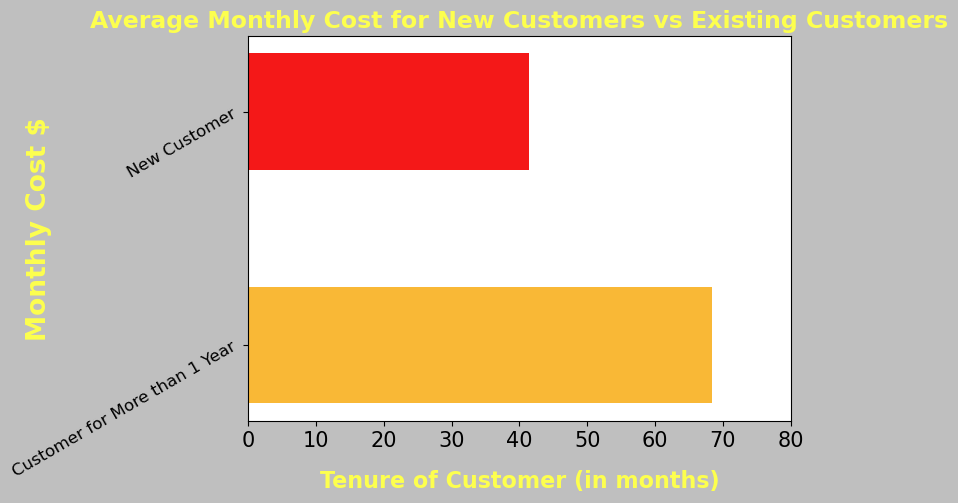

In [31]:
plt.style.use("grayscale")
plt.figure(figsize=(7, 5))
plt.barh(cust_old_vs_new_df["Customers"], cust_old_vs_new_df["Monthly Charge"], height = 0.5,
        color = ['#F9B836', '#F41818'])

plt.xlabel('Tenure of Customer (in months)', labelpad = 14.0, fontsize = 16.0, color = "#FDFF4E", weight = "bold")
plt.ylabel('Monthly Cost $', fontsize= 19.0, labelpad = -30, color = "#FDFF4E", weight = "bold")
plt.title('Average Monthly Cost for New Customers vs Existing Customers', color = "#FDFF4E", fontsize = 17, weight = "bold");
plt.xticks(fontsize = 15.0)
plt.xlim(0, 80)
plt.yticks(fontsize = 12.0, rotation = 30);

## How Long do People Stay with Telco?

In [32]:
tenure_df = df[["tenure", "Churn"]]
tenure_df

,tenure,Churn
0,1,No
1,34,No
2,2,Yes
3,45,No
4,2,Yes
...,...,...
7038,24,No
7039,72,No
7040,11,No
7041,4,Yes


In [33]:
tenure_df.loc[tenure_df["tenure"] > 48, "Length of Tenure"] = "> 48"
tenure_df.loc[(tenure_df["tenure"] >= 36) & (tenure_df["tenure"] < 48), "Length of Tenure"] = "36-48"
tenure_df.loc[(tenure_df["tenure"] >= 24) & (tenure_df["tenure"] < 36), "Length of Tenure"] = "24-36"
tenure_df.loc[(tenure_df["tenure"] >= 12) & (tenure_df["tenure"] < 24), "Length of Tenure"] = "12-24"                      
tenure_df.loc[tenure_df["tenure"] < 12, "Length of Tenure"] = "1-12"

tenure_df


C:\Users\Irochka\AppData\Local\Temp\ipykernel_12632\1005259931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tenure_df.loc[tenure_df["tenure"] > 48, "Length of Tenure"] = "> 48"


,tenure,Churn,Length of Tenure
0,1,No,1-12
1,34,No,24-36
2,2,Yes,1-12
3,45,No,36-48
4,2,Yes,1-12
...,...,...,...
7038,24,No,24-36
7039,72,No,> 48
7040,11,No,1-12
7041,4,Yes,1-12


In [34]:
tenure_df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

## How Long does it take for people that churn to leave the company?

In [35]:
condition_tenure = tenure_df["Churn"] == "Yes"
tenure_df = tenure_df[condition_tenure]
tenure_df

,tenure,Churn,Length of Tenure
2,2,Yes,1-12
4,2,Yes,1-12
5,8,Yes,1-12
8,28,Yes,24-36
13,49,Yes,> 48
...,...,...,...
7021,12,Yes,12-24
7026,9,Yes,1-12
7032,1,Yes,1-12
7034,67,Yes,> 48


In [36]:
num_tenures = tenure_df["Length of Tenure"].value_counts()
num_tenures

1-12     999
12-24    309
> 48     213
24-36    193
36-48    146
Name: Length of Tenure, dtype: int64

In [37]:
num_tenures = num_tenures.to_frame()

In [38]:
num_tenures = num_tenures.rename(columns = {'Length of Tenure':'Count'})
num_tenures['Length of Tenure'] = num_tenures.index
num_tenures

,Count,Length of Tenure
1-12,999,1-12
12-24,309,12-24
> 48,213,> 48
24-36,193,24-36
36-48,146,36-48


In [39]:
num_tenures.reset_index(drop = True, inplace = True)

In [40]:
num_tenures = num_tenures.sort_values(by = "Length of Tenure")
num_tenures

,Count,Length of Tenure
0,999,1-12
1,309,12-24
3,193,24-36
4,146,36-48
2,213,> 48


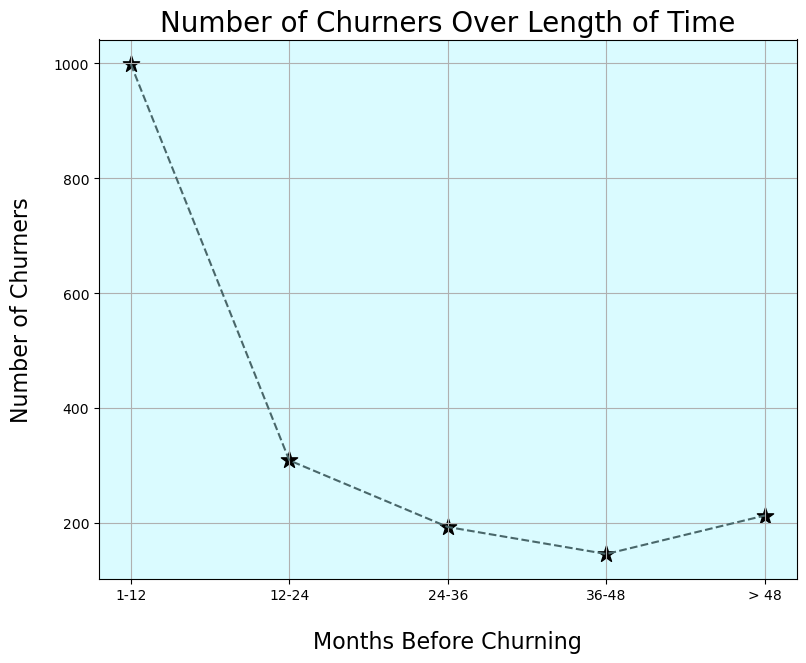

In [41]:
plt.style.use("default")
plt.figure(figsize=(9,7));  #size of graph in inches
ax = plt.axes()
 
# Setting the background color of the plot 
# using set_facecolor() method
ax.set_facecolor("#DAFBFF")
plt.scatter(num_tenures["Length of Tenure"], num_tenures["Count"], color = 'black', marker = '*', s = 150)
plt.title('Number of Churners Over Length of Time', fontsize=20);
plt.xlabel('Months Before Churning', fontsize=16, labelpad = 20);
plt.ylabel('Number of Churners', fontsize=16, labelpad = 15);
plt.plot(num_tenures["Length of Tenure"], num_tenures["Count"], c = "#49676A", ls = "--")
plt.grid();

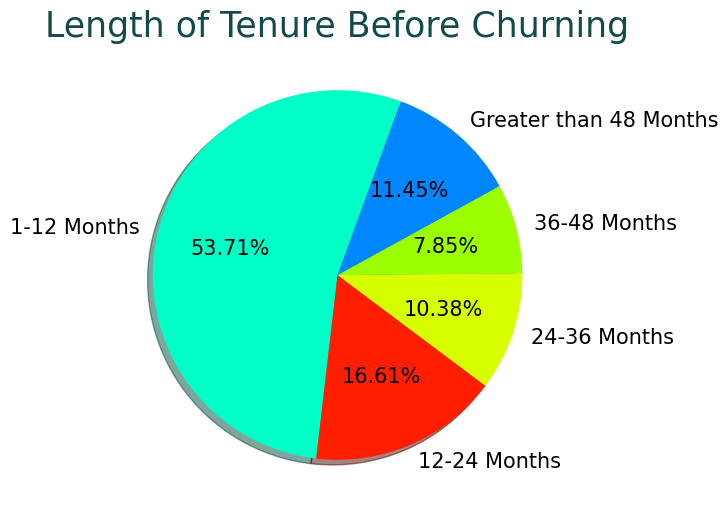

In [42]:
data = num_tenures["Count"]
labels = ["1-12 Months", "12-24 Months", "24-36 Months", "36-48 Months", "Greater than 48 Months"]
cmap = plt.colormaps["hsv"]
plt.figure(figsize=(9,6))   
plt.title("Length of Tenure Before Churning", fontsize = 25, 
          color = "#134A4C", pad=1);
plt.pie(data, labels=labels, colors = cmap([120, 5, 50, 60, 150]), autopct = '%.2f%%', shadow = True, 
        startangle = 70, textprops={'fontsize': 15});
# plt.legend(loc = "lower left", fontsize = 14);

In [43]:
pd.crosstab(df["Contract"], df["Churn"])

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


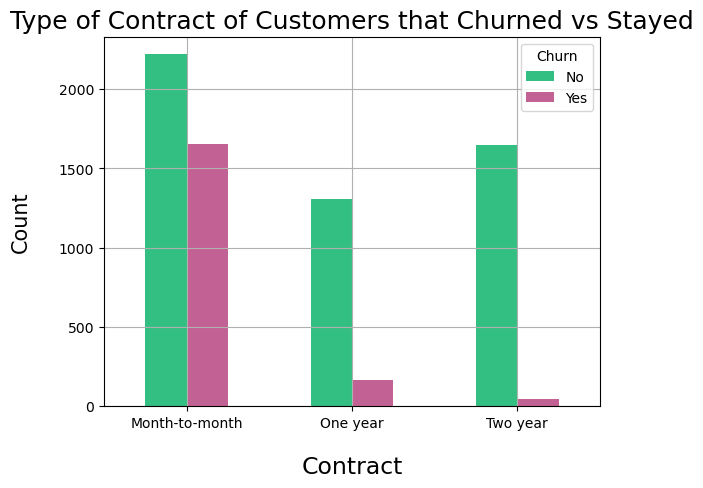

In [44]:
pd.crosstab(df["Contract"], df["Churn"]).plot(kind = "bar", color = ["#33BF81", "#C26193"])
plt.title("Type of Contract of Customers that Churned vs Stayed", fontsize = 18, color = "black");
plt.xlabel("Contract", labelpad = 18, fontsize = 17)
plt.xticks(rotation = 0)
plt.ylabel("Count", labelpad = 20, fontsize = 15)
plt.grid(); 

#there are far more churners with month to month contracts than year to year or two year contracts 

## Payment Method Effect on Churn

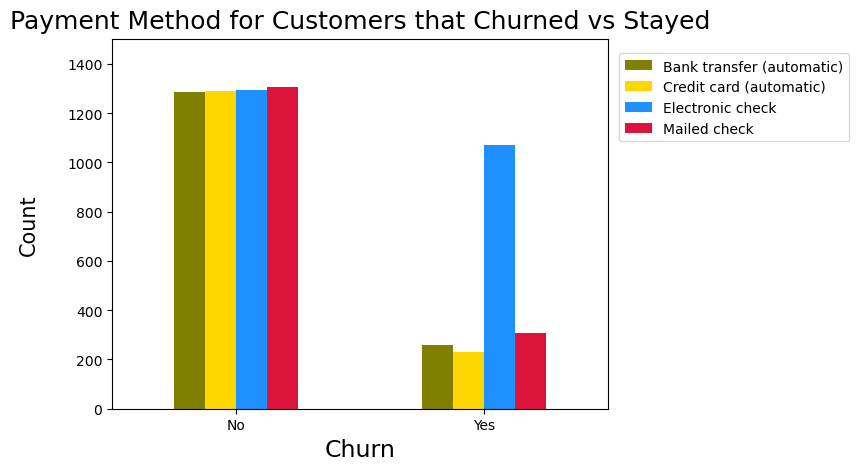

In [45]:
pd.crosstab(df["Churn"], df["PaymentMethod"]).plot(kind = "bar", color = ["olive", "gold", "dodgerblue", "crimson"])
plt.title("Payment Method for Customers that Churned vs Stayed", pad = 8, fontsize = 18, color = "black");
plt.xlabel("Churn", fontsize = 17)
plt.xticks(rotation = 0)
plt.ylabel("Count", labelpad = 20, fontsize = 15)
plt.ylim(0, 1500);
plt.legend(bbox_to_anchor=(1.5, 0.98)); 

## Online Security Effect on Churn

In [46]:
online_sec = pd.crosstab(df["Churn"], df["OnlineSecurity"])
online_sec

OnlineSecurity,No,No internet service,Yes
Churn,,,
No,2037,1413,1724
Yes,1461,113,295


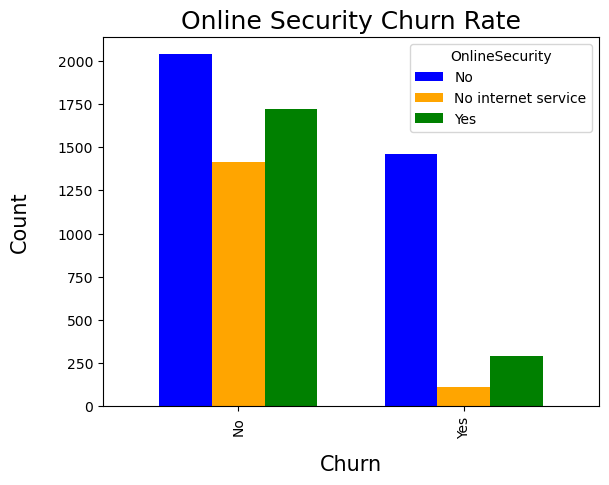

In [47]:
online_sec.plot(kind = "bar", color = ["blue", "orange", "green"], width = 0.7)
plt.title("Online Security Churn Rate", fontsize = 18, color = "black");
plt.xlabel("Churn", labelpad = 12, fontsize = 15)
plt.ylabel("Count", labelpad = 20, fontsize = 15);

In [48]:
length_and_contract = df.groupby("Contract")[["tenure"]].mean().round(2)
length_and_contract

,tenure
Contract,
Month-to-month,18.04
One year,42.04
Two year,56.74


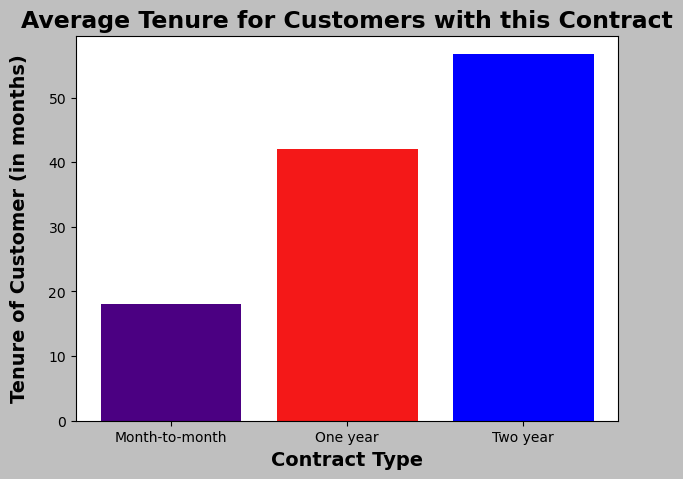

In [49]:
plt.style.use("grayscale")
plt.figure(figsize=(7, 5))
plt.bar(length_and_contract.index, length_and_contract["tenure"], color = ['indigo', '#F41818', "blue"])
plt.ylabel('Tenure of Customer (in months)', labelpad = 14.0, fontsize = 14.0, color = "black", weight = "bold")
plt.xlabel('Contract Type', fontsize= 14.0, color = "black", weight = "bold")
plt.title('Average Tenure for Customers with this Contract', color = "black", fontsize = 17, weight = "bold");

## Get Data Ready for Prediction:

## First drop the customer id column

In [50]:
df = df.drop("customerID", axis = 1)

### Now perform Label Encoding

We will convert each column that contains strings into numerical values. We will do this using LabelEncoder because we have much too many columns that need to be converted into numerical data after performing LabelEncoder, to increase accuracy and not let the model think the columns are ordered in some kind of numerical fashion, we will implement one hot encoding on the columns: 
"Online Security", "Payment Method", "Contract", and "Internet Service"

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [52]:
def convert_data(column):
    if column.dtype == 'object':
        column = LabelEncoder().fit_transform(column)
    return column

In [53]:
df = df.apply(lambda x: convert_data(x))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [54]:
df["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [55]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Build a correlation matrix to see the possible relationships that one feature has with another feature in the dataset

In [56]:
#let's first build a seaborn heatmap matrix with the mask

corr_matrix = df.corr()
corr_matrix

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.006739,-0.000863,-0.015017,-0.012057,0.000549,-0.006825,-0.006421,-0.008743,0.000126,-0.011754,0.017352,-0.014569,-0.000080,-0.008612
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.146185,-0.032310,-0.128221,-0.013632,-0.021398,-0.151268,0.030776,0.047266,-0.142554,0.156530,-0.038551,0.220173,0.103006,0.150889
Partner,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,0.142410,0.000891,0.150828,0.153130,0.166330,0.126733,0.137341,0.129574,0.294806,-0.014877,-0.154798,0.096848,0.317504,-0.150448
Dependents,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024991,0.044590,0.152166,0.091015,0.080537,0.133524,0.046885,0.021321,0.243187,-0.111377,-0.040292,-0.113890,0.062078,-0.164221
tenure,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.343032,-0.030359,0.325468,0.370876,0.371105,0.322942,0.289373,0.296866,0.671607,0.006152,-0.370436,0.247900,0.826178,-0.352229
PhoneService,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,-0.020538,0.387436,-0.015198,0.024105,0.003727,-0.019158,0.055353,0.043870,0.002247,0.016505,-0.004184,0.247398,0.113214,0.011942
MultipleLines,-0.006739,0.146185,0.142410,-0.024991,0.343032,-0.020538,1.000000,-0.109216,0.007141,0.117327,0.122318,0.011466,0.175059,0.180957,0.110842,0.165146,-0.176793,0.433576,0.452577,0.038037
InternetService,-0.000863,-0.032310,0.000891,0.044590,-0.030359,0.387436,-0.109216,1.000000,-0.028416,0.036138,0.044944,-0.026047,0.107417,0.098350,0.099721,-0.138625,0.086140,-0.323260,-0.175755,-0.047291
OnlineSecurity,-0.015017,-0.128221,0.150828,0.152166,0.325468,-0.015198,0.007141,-0.028416,1.000000,0.185126,0.175985,0.285028,0.044669,0.055954,0.374416,-0.157641,-0.096726,-0.053878,0.253224,-0.289309
OnlineBackup,-0.012057,-0.013632,0.153130,0.091015,0.370876,0.024105,0.117327,0.036138,0.185126,1.000000,0.187757,0.195748,0.147186,0.136722,0.280980,-0.013370,-0.124847,0.119777,0.374410,-0.195525


In [57]:
mask = np.zeros_like(corr_matrix)
upper_triangle_indices = np.triu_indices_from(mask)
mask[upper_triangle_indices] = True

<Axes: >

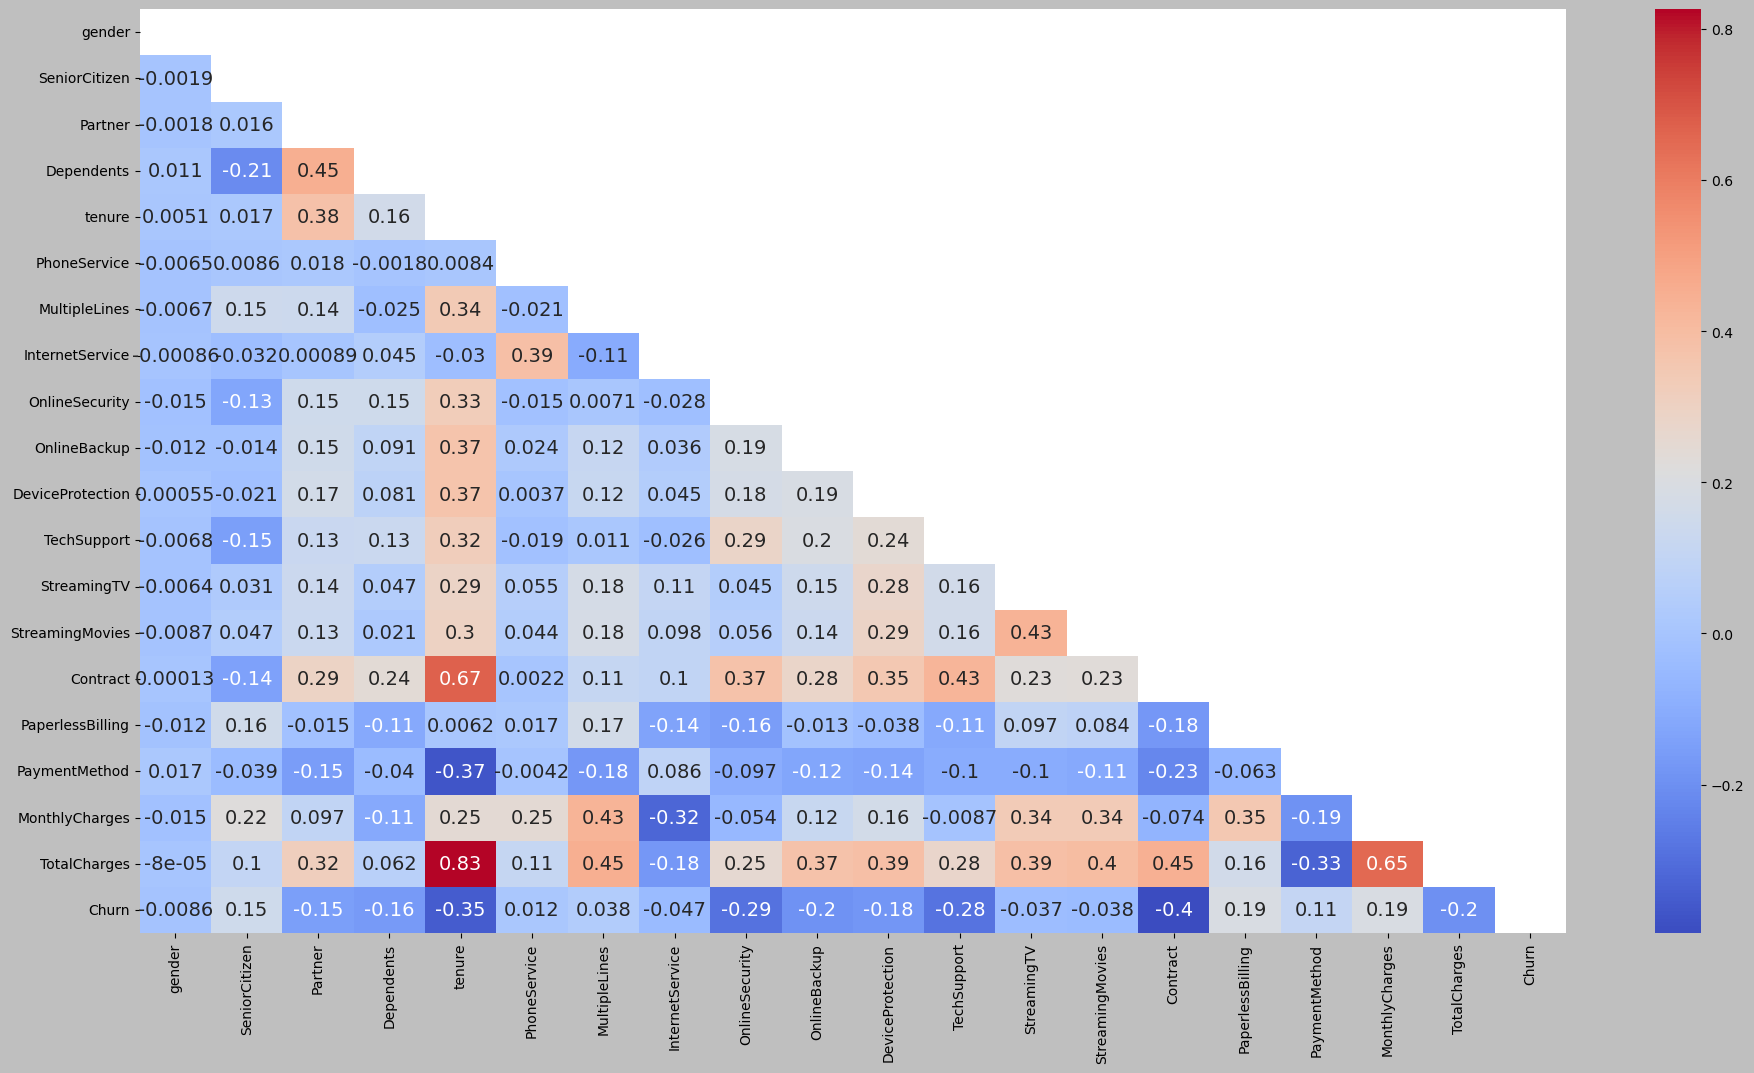

In [58]:
plt.figure(figsize=(23, 12))
plt.style.use("default")
sns.heatmap(corr_matrix, annot = True, mask = mask, cmap = "coolwarm", annot_kws = {"size": 14})

### Applying One Hot Encoding on the columns:"Online Security", "Payment Method", "Contract", and "Internet Service" 

In [59]:
df = pd.get_dummies(df, columns = ["OnlineSecurity", "PaymentMethod", "Contract", "InternetService"]) 
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Contract_0,Contract_1,Contract_2,InternetService_0,InternetService_1,InternetService_2
0,0,0,1,0,1,0,1,2,0,0,...,0,0,1,0,1,0,0,1,0,0
1,1,0,0,0,34,1,0,0,2,0,...,0,0,0,1,0,1,0,1,0,0
2,1,0,0,0,2,1,0,2,0,0,...,0,0,0,1,1,0,0,1,0,0
3,1,0,0,0,45,0,1,0,2,2,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,2,...,0,0,0,1,0,1,0,1,0,0
7039,0,0,1,1,72,1,2,2,2,0,...,0,1,0,0,0,1,0,0,1,0
7040,0,0,1,1,11,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
7041,1,1,1,0,4,1,2,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [60]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'OnlineSecurity_0',
       'OnlineSecurity_1', 'OnlineSecurity_2', 'PaymentMethod_0',
       'PaymentMethod_1', 'PaymentMethod_2', 'PaymentMethod_3', 'Contract_0',
       'Contract_1', 'Contract_2', 'InternetService_0', 'InternetService_1',
       'InternetService_2'],
      dtype='object')

## K- Nearest Neighbor Model:
## Scale the numerical features in the df using Normal Distribution Scaling (aka Standard Scaler)

In [61]:
X = df.drop("Churn", axis = "columns")
y = df["Churn"]

In [62]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int32

In [63]:
# Scale only the features: "tenure", "MonthlyCharges", and "TotalCharges"
data = X[["tenure", "MonthlyCharges","TotalCharges"]]
 
# compute required values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

# print scaled data
print(features_scaled[:3])

[[-1.27744458 -1.16032292 -0.99261052]
 [ 0.06632742 -0.25962894 -0.17216471]
 [-1.23672422 -0.36266036 -0.9580659 ]]


In [64]:
##Replace old features with newly scaled features

X[["tenure", "MonthlyCharges","TotalCharges"]] = features_scaled
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Contract_0,Contract_1,Contract_2,InternetService_0,InternetService_1,InternetService_2
0,0,0,1,0,-1.277445,0,1,2,0,0,...,0,0,1,0,1,0,0,1,0,0
1,1,0,0,0,0.066327,1,0,0,2,0,...,0,0,0,1,0,1,0,1,0,0
2,1,0,0,0,-1.236724,1,0,2,0,0,...,0,0,0,1,1,0,0,1,0,0
3,1,0,0,0,0.514251,0,1,0,2,2,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,-1.236724,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,-0.340876,1,2,0,2,2,...,0,0,0,1,0,1,0,1,0,0
7039,0,0,1,1,1.613701,1,2,2,2,0,...,0,1,0,0,0,1,0,0,1,0
7040,0,0,1,1,-0.870241,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
7041,1,1,1,0,-1.155283,1,2,0,0,0,...,0,0,0,1,1,0,0,0,1,0


## Regular KNN Model with nothing being applied to the imbalanced data!

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)

KNN accuracy: 0.7728348319924279


In [72]:
print(confusion_matrix(y_test, predicted_y))

[[1327  216]
 [ 264  306]]


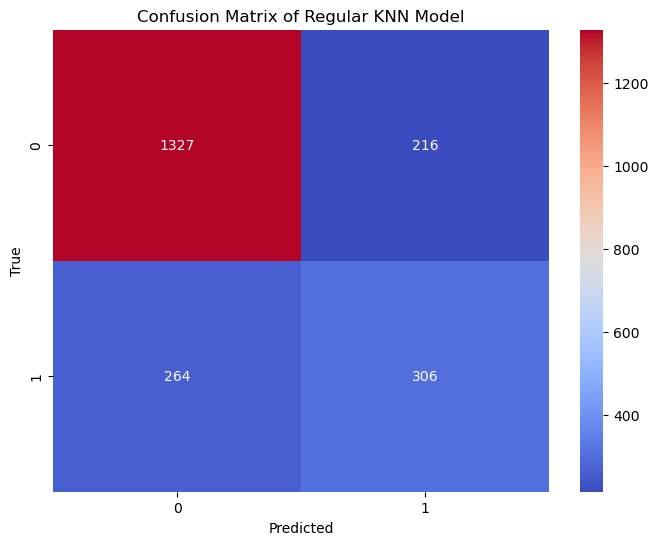

In [73]:
cm = confusion_matrix(y_test, predicted_y)
 
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d")
plt.title("Confusion Matrix of Regular KNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### The correlation matrix above clearly shows that the regular KNN model is biased towards the people who did not churn (the majority class. It is not performing well when it encounters customers when churned. We need to correct the number of false positive mistakes the model is making

## Optimal KNN Algorithm Using Feature Selection, Balanced Bagging with Random Oversampling, and Cross Validation

### First Perform Feature Selection using the Wrapper Method's Sequential Backward Elimination:

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

#Define the base classifier:
base_estimator = KNeighborsClassifier(n_neighbors = 11)

# Define the sequential backward search
feature_selector = SequentialFeatureSelector(base_classifier, n_features_to_select= "auto", 
                                             direction='backward', cv=5, tol = 0.03, scoring = "roc_auc")

feature_selector.fit(X_train, y_train)

# Access the indices of the selected features
selected_feature_indices = feature_selector.get_support(indices=True)

print("Selected Feature Indices:", selected_feature_indices)

Selected Feature Indices: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


### Next use Cross Validation to determine the best possible k value

### Cross Validation will be performed with the "Stratified K-Fold" Package)
### Note: Stratification is the process of rearranging the data to ensure each fold is a good representative of the whole (representative of both the majority and the minority class)

In [82]:
# Transform the data based on selected features

X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

#Set up Cross Validation for KNN
k_values = np.arange(1, 21)  #we will try k values in the range from 1 to 20

#Initialize an array to store Cross Validation scores for each value of k:
cv_scores = []

#Set up cross validation using StratifiedKFold, so we can better preserve the ratio of churners in each sample to non churners
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

#Iterate over each k value and perform Cross Validation:
for k in k_values:
    base_estimator = KNeighborsClassifier(n_neighbors = k)
    oversampler = RandomOverSampler(sampling_strategy = "auto", random_state = 42)
    
    bbc = BalancedBaggingClassifier(estimator = base_estimator, sampler = oversampler,
                                sampling_strategy='auto', replacement=True)
    
    #Perform cross validation and store the mean score
    scores = cross_val_score(bbc, X_train_selected, y_train, cv=cv)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

print(f"These are the cross validation scores for all k values from 1-21: \n {cv_scores}")
    
#choose the best k value, as long as k >= 7, so you avoid overfitting to the training data
# (You will find a k>=7 that has the highest cross-validation score)... so we begin cv_scores list at index = 6, to get k=7

cv_scores_beyond_k6 = cv_scores[6:]
best_k_index = np.argmax(cv_scores_beyond_k6) + 6
optimal_k = k_values[best_k_index]   
#we added 6 since the array should've started at index = 0, but we sliced it to begin at index = 6 (or k = 7)

print(f"The best k value >= 7 is: {optimal_k}")
print()
    

These are the cross validation scores for all k values from 1-21: 
 [0.7260492818439838, 0.7243488575442217, 0.7141199721911642, 0.7092021802700611, 0.7099558140534962, 0.7131760485651213, 0.7076834451420544, 0.7158234425618532, 0.7131737192167655, 0.7082514477795936, 0.7061720564204007, 0.7078728390814485, 0.7101457455348184, 0.7020037771279493, 0.7127947521573349, 0.7086318482841663, 0.7020043146698777, 0.7039018376766721, 0.7067368338063702, 0.7050340801582523]
The best k value >= 7 is: 8



### Now fit the balanced bagging classifier on the resampled and selected features and make sure to use the best k value!

In [83]:
base_estimator = KNeighborsClassifier(n_neighbors = optimal_k)
oversampler = RandomOverSampler(sampling_strategy = "auto", random_state = 42)
    
top_bbc = BalancedBaggingClassifier(estimator = base_estimator, sampler = oversampler,
                                sampling_strategy='auto', replacement=True)

top_bbc.fit(X_train_selected, y_train)

BalancedBaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=8),
                          replacement=True,
                          sampler=RandomOverSampler(random_state=42))

In [84]:
# Make predictions
y_pred = top_bbc.predict(X_test_selected)

y_predicted = top_bbc.predict(X_train_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Test: {accuracy}')

accuracy_train = accuracy_score(y_train, y_predicted)
print(f'Accuracy Train: {accuracy_train}')

Accuracy Test: 0.7223168654173765
Accuracy Train: 0.7960999621355547


In [85]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1282
           1       0.49      0.79      0.61       479

    accuracy                           0.72      1761
   macro avg       0.70      0.74      0.70      1761
weighted avg       0.79      0.72      0.74      1761



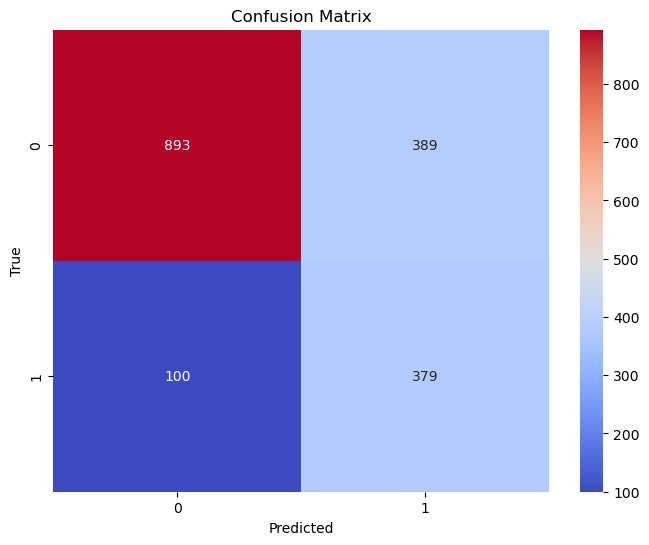

In [86]:
cm = confusion_matrix(y_test, y_pred)
 
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Decision Tree with weights = balanced

In [93]:
X = df.drop("Churn", axis = "columns")
y = df["Churn"]

### Note there is no need to perform feature selection on a decision tree, because when splitting the nodes, the decision tree selects the features that contribute the highest information gain

In [94]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create Decision Tree classifier with balanced class weights and grow it out completely (we will prune based
# on the validation set after it's grown out)
fully_grown_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
fully_grown_dt.fit(X_train, y_train)

# Now let's evaluate the fully grown tree on the validation set. 
# We will adjust the max_depth of the tree each time to see which max_depth gets us the best accuracy on the validation set.
# In a way, we are performing cross validation, but we are using the validation set to test the accuracy of the pruned tree.

val_accuracies = []
depths_to_try = range(1, fully_grown_dt.get_depth() + 1)

for max_depth in depths_to_try:
    pruned_dt_classifier = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=42)
    pruned_dt_classifier.fit(X_train, y_train)
    y_val_pred_pruned = pruned_dt_classifier.predict(X_val)
    val_accuracies.append(accuracy_score(y_val, y_val_pred_pruned))

# Find the max_depth that provides the best performance on the validation set
best_max_depth = depths_to_try[val_accuracies.index(max(val_accuracies))]

# Train the final pruned Decision Tree with the best max_depth on the entire training set
final_pruned_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=best_max_depth, random_state=42)
final_pruned_dt.fit(X_train, y_train)

# Evaluate the final model on the train and test set
y_train_pred = final_pruned_dt.predict(X_train)
y_test_pred = final_pruned_dt.predict(X_test)
print("Best Max Depth:", best_max_depth)
print("Train Accuracy (Final Pruned Tree):", accuracy_score(y_train, y_train_pred))
print("Test Accuracy (Final Pruned Tree):", accuracy_score(y_test, y_test_pred))

Best Max Depth: 5
Train Accuracy (Final Pruned Tree): 0.771684509504042
Test Accuracy (Final Pruned Tree): 0.7583130575831306


#### Note the test_size = 0.35. This means that 35% of the orignal data is going to be used for testing the training data and creating a validation set. Out of this 35%, half of this data will be used only for X test and y test, and the other half will be used for the validation set. Thus, 0.35 * 0.5 * 100 = 17.5% of the data will be used for testing and 17.5% will be used as a validation set

In [104]:
print("Classification Report (Final Pruned Tree):",\n classification_report(y_test, y_test_pred))

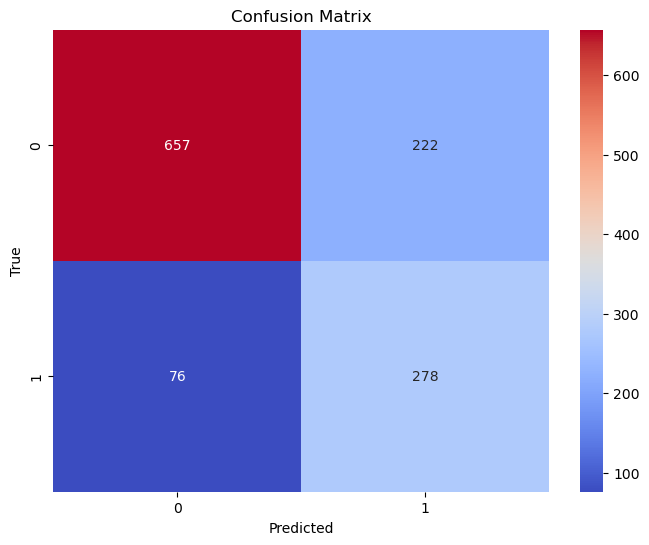

In [96]:
cm = confusion_matrix(y_test, y_test_pred)
 
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Random Forest (naturally handles the imbalanced data set with less prone to overfitting)

In [97]:
X = df.drop("Churn", axis = "columns")
y = df["Churn"]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

#this creates a balanced random forest where more weight is applied to the minority class to prevent bias
brf = RandomForestClassifier(class_weight = "balanced", random_state=42)

brf.fit(X_train, y_train)

y_train_pred = brf.predict(X_train)
print("Train Accuracy", accuracy_score(y_train, y_train_pred))

y_test_pred = brf.predict(X_test)
print("Test Accuracy", accuracy_score(y_test, y_test_pred))
#Accuracy 0.8

Train Accuracy 0.998485422188565
Test Accuracy 0.7876206700738216


In [99]:
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1282
           1       0.66      0.45      0.54       479

    accuracy                           0.79      1761
   macro avg       0.74      0.68      0.70      1761
weighted avg       0.77      0.79      0.77      1761



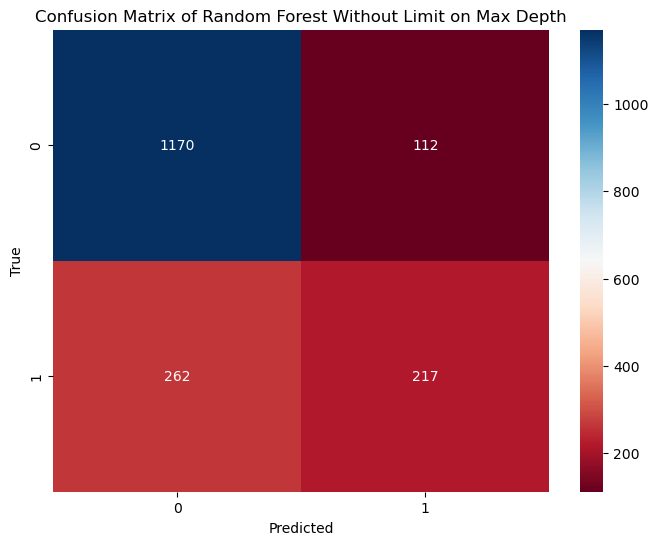

In [100]:
cm = confusion_matrix(y_test, y_test_pred)
 
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="RdBu", fmt="d")
plt.title("Confusion Matrix of Random Forest Without Limit on Max Depth")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Now implement a Random Forest while setting a limit on the Max Depth for each tree, so you avoid overfitting

In [134]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# List of max depths to test
max_depths_to_test = np.arange(1, 11)

# Dictionary to store training accuracies for each max depth
training_accuracies = {}

# Iterate over max depths and evaluate training accuracy
for max_depth_value in max_depths_to_test:
    # Create a Balanced Random Forest classifier with the current max depth
    brf_classifier = RandomForestClassifier(class_weight='balanced', max_depth=max_depth_value, random_state=42)
    
    # Train the model
    brf_classifier.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = brf_classifier.predict(X_train)
    
    # Calculate training accuracy
    training_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Store the training accuracy in the dictionary
    training_accuracies[max_depth_value] = training_accuracy

# Print the training accuracies for each max depth
for max_depth, accuracy in training_accuracies.items():
    print(f"Max Depth: {max_depth}, Training Accuracy: {accuracy}")

Max Depth: 1, Training Accuracy: 0.7093903824308974
Max Depth: 2, Training Accuracy: 0.7194244604316546
Max Depth: 3, Training Accuracy: 0.7315410829231351
Max Depth: 4, Training Accuracy: 0.7347595607724347
Max Depth: 5, Training Accuracy: 0.7510412722453617
Max Depth: 6, Training Accuracy: 0.7614539946989777
Max Depth: 7, Training Accuracy: 0.7824687618326391
Max Depth: 8, Training Accuracy: 0.8087845513063233
Max Depth: 9, Training Accuracy: 0.8351003407800076
Max Depth: 10, Training Accuracy: 0.8629307080651268


In [135]:
#find closest training accuracy between 0.8 and 0.85 => 0.825: (this is the max depth that we will choose)

new_lst = []
for val in training_accuracies.values():
    val = val - 0.825
    val = abs(val)
    new_lst.append(val)

arry_closest = np.array(new_lst)
arry_closest

array([0.11560962, 0.10557554, 0.09345892, 0.09024044, 0.07395873,
       0.06354601, 0.04253124, 0.01621545, 0.01010034, 0.03793071])

In [136]:
# Find the best max depth based on training accuracy
best_max_depth = np.argmin(arry_closest) + 1

# Print the best max depth
print(f"Best Max Depth: {best_max_depth}, Training Accuracy: {training_accuracies[best_max_depth]}")

# Create a Balanced Decision Tree classifier with the best max depth
best_depth_brf_classifier = RandomForestClassifier(class_weight='balanced', max_depth=best_max_depth, random_state=42)

# Train the model
best_depth_brf_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = best_depth_brf_classifier.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print("Test Accuracy:", test_accuracy)

Best Max Depth: 9, Training Accuracy: 0.8351003407800076
Test Accuracy: 0.7762634866553095


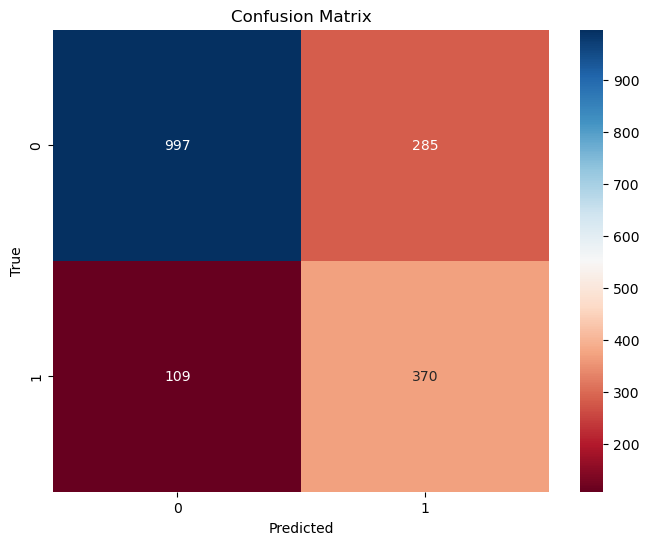

In [137]:
cm = confusion_matrix(y_test, y_test_pred)
 
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="RdBu", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## the confusion matrix above shows that the Random Forest algorithm performed significantly better on the minority class when it was given a max depth parameter that each tree could reach. This algorithm had a much higher "Specificity score" compared with the regular Random Forest Algorithm

#### End of Project Code 

## Practiced Code (Not part of final project)

### Use Balanced Bagging Classifier to create random undersamples of majority class and handle the Imbalanced Data set

In [65]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [66]:
# base_estimator = KNeighborsClassifier(n_neighbors = 9)
# bbc = BalancedBaggingClassifier(base_estimator=base_estimator, n_estimators = 5, 
#                                 sampling_strategy='auto', replacement=True)

In [67]:
# bbc.fit(X_train, y_train)

In [68]:
# y_pred = bbc.predict(X_test)
# test_accuracy_knn_bbc = bbc.score(X_test,y_test)
# print("KNN Test Accuracy with Bagging:", test_accuracy_knn_bbc)

# train_accuracy_knn_bbc = bbc.score(X_train,y_train)
# print("KNN Training Accuracy with Bagging:", train_accuracy_knn_bbc)




In [69]:
# print(confusion_matrix(y_test, y_pred))

In [70]:
# print(classification_report(y_test, y_pred))

## Balanced Bagging with Underfitting

In [78]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# #Define the base classifier:
# base_classifier = KNeighborsClassifier(n_neighbors = 11)

# #sequential backward search
# feature_selector = SequentialFeatureSelector(base_classifier, direction = "backward")

# feature_selector.fit(X_train, y_train)

# selected_feature_indices = feature_selector.get_support(indices = True)



In [80]:
# print(f"Selected Features are: {selected_feature_indices}")

In [76]:
# X_train_selected = feature_selector.transform(X_train)
# X_test_selected = feature_selector.transform(X_test)

In [79]:
# bbc = BalancedBaggingClassifier(base_estimator=base_estimator, n_estimators = 5, 
#                                 sampling_strategy='auto', replacement=True)
# bbc.fit(X_train_selected, y_train)

# y_pred = bbc.predict(X_test_selected)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

In [ ]:
# print(confusion_matrix(y_test, y_pred))

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
 
# # Visualize confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

## Using Oversampling and Bagging at the same time:

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

# #Define the base classifier:
# base_estimator = KNeighborsClassifier(n_neighbors = 11)

# # Define the sequential backward search
# feature_selector = SequentialFeatureSelector(base_classifier, n_features_to_select= "auto", 
#                                              direction='backward', cv=5, tol = 0.02)

# feature_selector.fit(X_train, y_train)

# # Access the indices of the selected features
# selected_feature_indices = feature_selector.get_support(indices=True)

# print("Selected Feature Indices:", selected_feature_indices)

In [ ]:
# # Transform the data based on selected features

# X_train_selected = feature_selector.transform(X_train)
# X_test_selected = feature_selector.transform(X_test)

# # Apply oversampling to the selected features
# oversampler = RandomOverSampler(sampling_strategy = "auto", random_state = 42)
# bbc = BalancedBaggingClassifier(base_estimator = base_estimator, sampler = oversampler,
#                                 sampling_strategy='auto', replacement=True)

# # Fit the balanced bagging classifier on the resampled and selected features
# bbc.fit(X_train_selected, y_train)


In [ ]:
# # Make predictions
# y_pred = bbc.predict(X_test_selected)

# y_predicted = bbc.predict(X_train_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

# accuracy_train = accuracy_score(y_train, y_predicted)
# print(f'Accuracy Train: {accuracy_train}')

In [ ]:
# report = classification_report(y_test, y_pred)
# print(report)

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
 
# # Visualize confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

## Perform Sequential Backward Elimination while using AUC ROC scoring instead of accuracy scoring, because this is a much more efficient way of judging the optimal features to select, especially when the data is imbalanced!

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

# #Define the base classifier:
# base_estimator = KNeighborsClassifier(n_neighbors = 11)

# # Define the sequential backward search
# feature_selector = SequentialFeatureSelector(base_classifier, n_features_to_select= "auto", 
#                                              direction='backward', cv=5, tol = 0.02, scoring = "roc_auc")

# feature_selector.fit(X_train, y_train)

# # Access the indices of the selected features
# selected_feature_indices = feature_selector.get_support(indices=True)

# print("Selected Feature Indices:", selected_feature_indices)

In [ ]:
# # Transform the data based on selected features

# X_train_selected = feature_selector.transform(X_train)
# X_test_selected = feature_selector.transform(X_test)

# # Apply oversampling to the selected features
# oversampler = RandomOverSampler(sampling_strategy = "auto", random_state = 42)
# bbc = BalancedBaggingClassifier(base_estimator = base_estimator, sampler = oversampler,
#                                 sampling_strategy='auto', replacement=True)

# # Fit the balanced bagging classifier on the resampled and selected features
# bbc.fit(X_train_selected, y_train)

In [ ]:
# # Make predictions
# y_pred = bbc.predict(X_test_selected)

# y_predicted = bbc.predict(X_train_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

# accuracy_train = accuracy_score(y_train, y_predicted)
# print(f'Accuracy Train: {accuracy_train}')

In [ ]:
# report = classification_report(y_test, y_pred)
# print(report)

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
 
# # Visualize confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()